In this notebook I plan to find what separations should produce WD+WD systems that merge within a hubble time in the adaptive importive sampling (AIS) COMPAS output
The plan:

- Get a dataset with all of the WD+WD binaries
- Make a function for separations
- Make histograms or distribution plots to find the min and maximum masses of these systems and the lifetime of the system
- Use this to analzye the three cases:
    - min(M1), min(M2), t_life(min(M2))
    - max(M1), max(M2), t_life(max(M2))
    - max(M1), min(M2), t_life(min(M2))
- plot the separation distirbution we get from all of the WD+WD
    - plot the separation from each of the three cases
    - also use the separation function to plot what the separation would be if t_life = t_hubble
    - also plot the case when R1+R2 = a (when a stellar merger would occur)

In [1]:
#importing, make sure the kernel is correct or the module will be unknown
import h5py as h5
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
from useful_fncs import tgw,WD_BINARY_BOOLS,WDWD_bools,separations

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

#### Let's import the AIS COMPAS output

In [2]:
# reading in the HDF5 file
pathToAIS_H5 = '/mnt/home/msantiago/ceph/data/COMPAS_Output_wWeights_SM.h5' #path of the hdf5 file

Data_AIS = h5.File(pathToAIS_H5)

In [116]:
# units check

SPs = Data_AIS['BSE_System_Parameters']
print(SPs['SemiMajorAxis'].attrs['units'])

b'Rsol'


In [3]:
# let's gather the system parameters group 

SP_WD_AIS = pd.DataFrame() # making a pandas dataframe

for key in Data_AIS["BSE_System_Parameters"].keys(): #looping through the "keys" or paramters in BSE_System_Parameters

    SP_WD_AIS[key] = Data_AIS["BSE_System_Parameters"][key][()] # adding these columns to the dataframe

Let's now select for just the WD+WD systems

In [4]:
BWD_BOOL = WDWD_bools(SP_WD_AIS)
WDWD_AIS_SYS = SP_WD_AIS[BWD_BOOL]

Let's double check that these are all only WD+WD

Text(0.5, 1.0, 'Stellar Types in Each System')

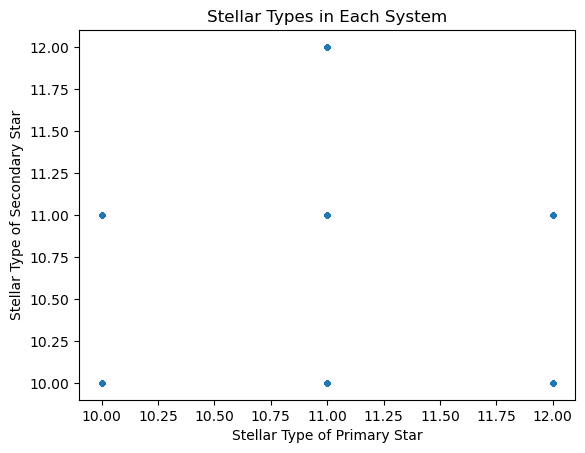

In [5]:
plt.plot(WDWD_AIS_SYS['Stellar_Type(1)'],WDWD_AIS_SYS['Stellar_Type(2)'],'.')
plt.xlabel("Stellar Type of Primary Star")
plt.ylabel("Stellar Type of Secondary Star")
plt.title("Stellar Types in Each System")

#### We need to rarrange the coalescence time equation to get something representative of separations

In [153]:
"""
This function will give the maximum separation needed for a bianry to merge within a hubble time given the massesand lifetime of the system
"""
def separations(e,Mmoremass,Mlessmass,t_life):

    """
    e = eccentricity
    t_hubble = age of the universe
    Mmoremass = mass of the more massive compact object (expected in solar masses!)
    Mlessmass = mass of the less massive compact object (expected in solar masses!)
    """

    age_universe = (13.7e9*u.yr).to(u.s)

    if t_life > age_universe.value:
        
        return print("The age of your binary surpasses that of the age of the universe (ypur binary is still forming).")


    else:

        Mmoremass = (Mmoremass * u.Msun).to(u.kg)
        Mlessmass = (Mlessmass * u.Msun).to(u.kg)

        a_min_den = (1/(5*(const.c**5)))*((age_universe-((t_life*u.Myr).to(u.s)))*(256*(const.G**3)*Mmoremass*Mlessmass*(Mmoremass+Mlessmass)))
        a_min_num = ((1+(0.27*e**10)+(0.33*e**20)+(0.2*e**1000))*(1-(e**2))**(7/2))**(1/4)
        a_min_final = ((a_min_den/a_min_num)**(1/4)).to(u.Rsun)


        return (a_min_final).value

In [154]:
# let's test the function to make sure it is reasonable
separations(0,0.8,0.2,1000)

1.9178306338690954

In [155]:
# a sanity test to make sure the function is actually giving what it should

test = (((4.32e17-(3.15e16))*(256*(const.G.value**3)*(1.6e30)*(4e29)*(1.6e30+4e29)))/((5*(const.c.value**5))*((1+(0.27*0**10)+(0.33*0**20)+(0.2*0**1000))*(1-(0**2))**(7/2))))**(1/4)

test*(1.437e-9)

1.9253327354515541

#### Let's make the mass distibruons for these systems

Text(0.5, 1.0, 'Mass Distribution of the Primary Star')

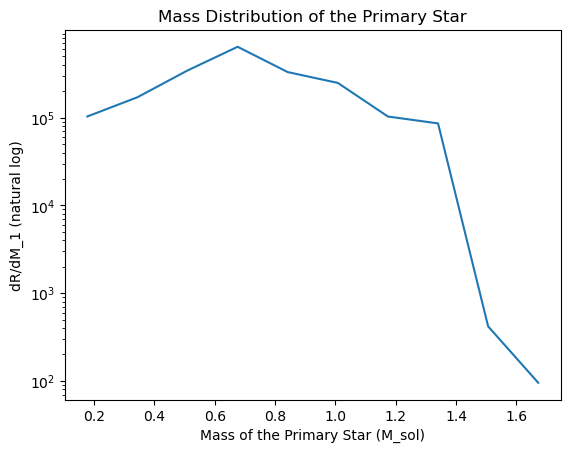

In [156]:
# primary mass distribution

# below makes it so if i change the number of bins or anything like that it will not change th eshaoe if the distribution
hist, bin_edges = np.histogram(WDWD_AIS_SYS['Mass(1)'], weights=WDWD_AIS_SYS['mixture_weight'])
center_bins = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = np.diff(bin_edges)

plt.plot(center_bins,hist/bin_width)
plt.xlabel("Mass of the Primary Star (M_sol)")
plt.yscale('log')
# plt.ylim(1e-1,1e3)
plt.ylabel("dR/dM_1 (natural log)")
plt.title("Mass Distribution of the Primary Star")

In [157]:
print("The minimum mass of the primary star is", min(WDWD_AIS_SYS['Mass(1)']),"M_sun")
print("The maximum mass of the primary star is", max(WDWD_AIS_SYS['Mass(1)']),"M_sun")

The minimum mass of the primary star is 0.09474842290206931 M_sun
The maximum mass of the primary star is 1.7556418126383084 M_sun


Since this lower mass is so extreme we will pick M1_min ~ 0.4 M_sun and M1_max ~ 1.3 M_sun

Text(0.5, 1.0, 'Mass Distribution of the Secondary Star')

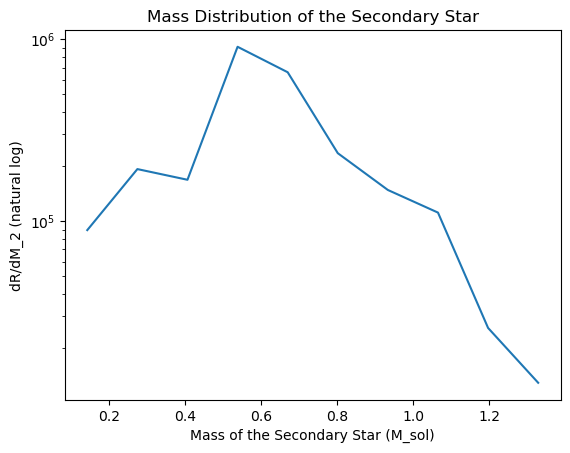

In [158]:
# secondary mass distribution

# below makes it so if i change the number of bins or anything like that it will not change th eshaoe if the distribution
hist, bin_edges = np.histogram(WDWD_AIS_SYS['Mass(2)'], weights=WDWD_AIS_SYS['mixture_weight'])
center_bins = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = np.diff(bin_edges)

plt.plot(center_bins,hist/bin_width)
plt.xlabel("Mass of the Secondary Star (M_sol)")
plt.yscale('log')
# plt.ylim(1e-1,1e3)
plt.ylabel("dR/dM_2 (natural log)")
plt.title("Mass Distribution of the Secondary Star")

In [159]:
print("The minimum mass of the secondary star is", min(WDWD_AIS_SYS['Mass(2)']),"M_sun")
print("The maximum mass of the secondary star is", max(WDWD_AIS_SYS['Mass(2)']),"M_sun")

The minimum mass of the secondary star is 0.07720048145814043 M_sun
The maximum mass of the secondary star is 1.394248912017169 M_sun


Since this lower mass is so extreme we will pick M2_min ~ 0.3 M_sun and M2_max ~ 0.8 M_sun

Let's find the lifetimes we need for each of the three cases

Text(12350, 1, 'Hubble Time')

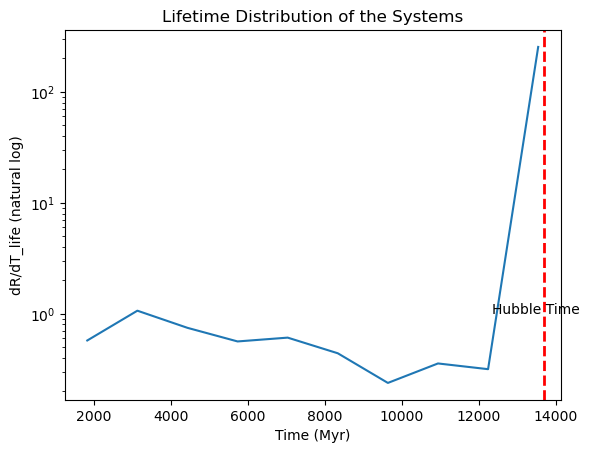

In [174]:
# first let's just look at the lifetime disitbutions

# below makes it so if i change the number of bins or anything like that it will not change the shape if the distribution
hist, bin_edges = np.histogram(WDWD_AIS_SYS['Time'], weights=WDWD_AIS_SYS['mixture_weight'])
center_bins = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = np.diff(bin_edges)

plt.plot(center_bins,hist/bin_width)
plt.xlabel("Time (Myr)")
plt.yscale('log')
# plt.ylim(1e-1,1e3)
plt.ylabel("dR/dT_life (natural log)")
plt.title("Lifetime Distribution of the Systems")

# # the age of the universe
age_universe = (13.7e9)*(1e-6) # converting from yr to Myr

plt.axvline(age_universe, color='r', linestyle='--', linewidth=2)
plt.text(12350, 10**0, "Hubble Time", fontsize=10)

In [175]:
larger_hubble_bool = WDWD_AIS_SYS['Time'] > age_universe
sum(larger_hubble_bool)

846112

In [176]:
smaller_hubble_bool = WDWD_AIS_SYS['Time'] < age_universe
sum(smaller_hubble_bool)

1205

Let's choose a longer lifetime for the lower mass case:
- 13100 Myr

A shorter lifetime for the higher mass case:
- 12500 Myr

An in between lifetime for the mixed case:
- 13100 Myr

It seems that most of the lifetimes are below hubble time but let's compute the actual values

In [178]:
# # case 1 -  the min(M1), min(M2) (we care about M2 because it dominates the evolution of the system)
# m2_min_bool = WDWD_AIS_SYS['Mass(2)']==min(WDWD_AIS_SYS['Mass(2)'])
# time_1 = WDWD_AIS_SYS[m2_min_bool]['Time'].iloc[0]

# # case 2 - max(M1), max(M2) 
# m2_max_bool = WDWD_AIS_SYS['Mass(2)']==max(WDWD_AIS_SYS['Mass(2)'])
# time_2 = WDWD_AIS_SYS[m2_max_bool]['Time'].iloc[0]

# # case 3 - max(M1), min(M1) 
# time_3 = WDWD_AIS_SYS[m2_min_bool]['Time'].iloc[0]


In [179]:
# print(time_3)
# print(13.7e9/(1e6))

It seems that these values are larger than hubble time so they have not even begun their inspiral stage yet

In [163]:
WDWD_AIS_SYS.loc[WDWD_AIS_SYS['Time']<13700]

,Applied_Kick_Magnitude(1),Applied_Kick_Magnitude(2),CE_Alpha,CE_Event_Counter,CH_on_MS(1),CH_on_MS(2),Drawn_Kick_Magnitude(1),Drawn_Kick_Magnitude(2),Eccentricity,Eccentricity@ZAMS,...,Sigma_Kick_USSN,Stellar_Type(1),Stellar_Type(2),Stellar_Type@ZAMS(1),Stellar_Type@ZAMS(2),SystemicSpeed,Time,Unbound,WR_Factor,mixture_weight
13,0.0,0.0,1.0,2,0,0,0.0,0.0,0.0,0.0,...,30.0,11,10,1,1,0.0,2203.361047,0,1.0,6.633484
282,0.0,0.0,1.0,2,0,0,0.0,0.0,0.0,0.0,...,30.0,11,10,1,1,0.0,1661.616350,0,1.0,9.812540
390,0.0,0.0,1.0,1,0,0,0.0,0.0,0.0,0.0,...,30.0,10,10,1,1,0.0,1987.560727,0,1.0,10.000000
678,0.0,0.0,1.0,1,0,0,0.0,0.0,0.0,0.0,...,30.0,11,10,1,1,0.0,2808.980120,0,1.0,9.999974
682,0.0,0.0,1.0,1,0,0,0.0,0.0,0.0,0.0,...,30.0,10,10,1,1,0.0,6553.614307,0,1.0,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990696,0.0,0.0,1.0,2,0,0,0.0,0.0,0.0,0.0,...,30.0,10,10,1,1,0.0,3876.053724,0,1.0,1.411546
994640,0.0,0.0,1.0,2,0,0,0.0,0.0,0.0,0.0,...,30.0,10,10,1,1,0.0,4344.323222,0,1.0,1.385454
995736,0.0,0.0,1.0,2,0,0,0.0,0.0,0.0,0.0,...,30.0,10,10,1,1,0.0,3659.690788,0,1.0,1.135102
996451,0.0,0.0,1.0,2,0,0,0.0,0.0,0.0,0.0,...,30.0,10,10,1,1,0.0,9220.525957,0,1.0,4.504378


It seems that the only systems that have lifetimes smaller than a hubble time are those that we has thought produced GW mergers but do not

#### Let's calculate the separations corresponding to these values

In [180]:
a_case1 = separations(0,0.4,0.3,13100)

a_case2 = separations(0,1.3,0.8,12000)

a_case3  = separations(0,1.3,0.3,13100)


#### Let's compute the cases for when t_life = t_life

In [170]:
a_case_hubble_1 = separations(0,min(WDWD_AIS_SYS['Mass(1)']),min(WDWD_AIS_SYS['Mass(2)']),13600)
a_case_hubble_1


0.17010895567712692

#### Let's plot the separations distribution

Text(1000, 0.1, 'a=100 R_sun')

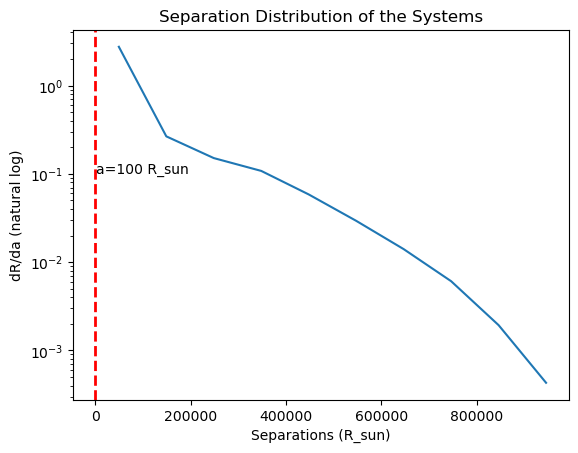

In [196]:
# separation distribtuions

# below makes it so if i change the number of bins or anything like that it will not change the shape if the distribution
hist, bin_edges = np.histogram(WDWD_AIS_SYS['SemiMajorAxis'], weights=WDWD_AIS_SYS['mixture_weight'])
center_bins = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = np.diff(bin_edges)

plt.plot(center_bins,hist/bin_width)
plt.xlabel("Separations (R_sun)")
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-1,1e3)
plt.ylabel("dR/da (natural log)")
plt.title("Separation Distribution of the Systems")

plt.axvline(100, color='r', linestyle='--', linewidth=2)
plt.text(1000, 10**-1, "a=100 R_sun", fontsize=10)
# plt.axvline(a_case1, color='r', linestyle='--', linewidth=2)
# plt.axvline(a_case2, color='r', linestyle='--', linewidth=2)
# plt.axvline(a_case3, color='r', linestyle='--', linewidth=2)


In [197]:
small_separations_bool = WDWD_AIS_SYS['SemiMajorAxis'] < 100
sum(small_separations_bool)

69607

Text(0.5, 1.0, 'Separation Distribution of the Systems')

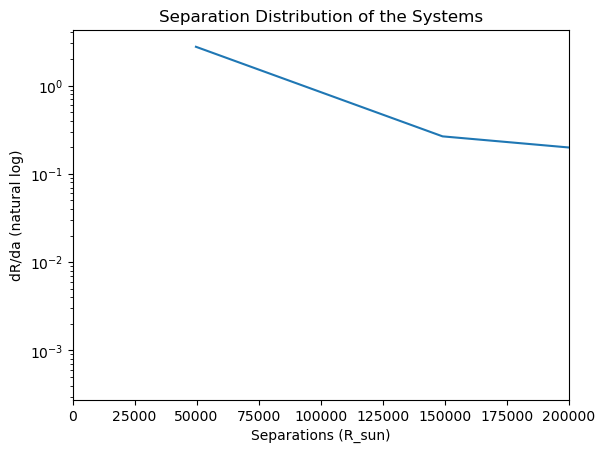

In [115]:
# separation distribtuions

# below makes it so if i change the number of bins or anything like that it will not change the shape if the distribution
hist, bin_edges = np.histogram(WDWD_AIS_SYS['SemiMajorAxis'], weights=WDWD_AIS_SYS['mixture_weight'])
center_bins = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = np.diff(bin_edges)

plt.plot(center_bins,hist/bin_width)
plt.xlabel("Separations (R_sun)")
plt.yscale('log')
plt.xlim(0,2e5)
plt.ylabel("dR/da (natural log)")
plt.title("Separation Distribution of the Systems")


In [118]:
WDWD_AIS_SYS['SemiMajorAxis']

3              1.818213
5          10263.665097
6           3519.609779
9           4344.926196
10             1.962806
              ...      
999995      8070.434316
999996     25738.967556
999997    492165.870155
999998    120948.185496
999999     52920.964583
Name: SemiMajorAxis, Length: 847317, dtype: float64